- Molecule Representation Tutorial : https://www.kaggle.com/code/sdlee94/belka-molecule-representations-for-ml-tutorial
- Goal : Smiles식으로 'IC50_nM(Target)' 유추하기
-
- Chem.MolFromSmiles : Chemical Imfomatic에서 자주 이용되는 library. 'SMILES -> RDKit object' converting에 유용함.
- ChEMBL : Database of bioactive molecules

ChEMBL DB
- 생물학적 활성, 약리학적 profile, SMILES 등을 포함한 db.
- 화합물이 결합하거나 영향을 미치는 target 단백질에 대한 정보도 포함됨.
- IC50 : 시험관 내에 있는 생물학적 과정(성분)을 50% 억제하는데 필요한 양
- pChEMBL Value : 화합물이 특정 생물학적 target에 얼마나 강하게 작용하는가
- pLC50 : log of LC50(Lethal Concentration, 독성 물질이 실험 동물 50%를 사망시키는 농도)

In [ ]:
# for basic SMILES operations, descriptors and fingerprints
!pip install -q rdkit
!pip install -q rdkit-pypi

# for chemical language models
!pip install -q transformers

# for graphs
!pip install -q dgl

# for mol2vec
!pip install -q mol2vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.3 MB/s eta 0:00:00


# 01. Import Library and load DataSet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import * # Scaler

# For basic SMILES operations, descriptors and fingerprints
from rdkit import *
from rdkit.Chem import *
from rdkit.ML.Descriptors import *

# For mol2vec
from gensim.models import *
from mol2vec.features import *

# For chemical language models
from transformers import *

# For graphs
import torch

from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.metrics import * # Score Criteria

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
target = 'IC50_nM'
seed = 42

# 02. First Step to EDA

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [ ]:
train.info() # Categorical columns 매우 많다...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Value      1952 non-null   float64
 4   Standard Units      1952 non-null   object 
 5   pChEMBL Value       1952 non-null   float64
 6   Assay ChEMBL ID     1952 non-null   object 
 7   Target ChEMBL ID    1952 non-null   object 
 8   Target Name         1952 non-null   object 
 9   Target Organism     1952 non-null   object 
 10  Target Type         1952 non-null   object 
 11  Document ChEMBL ID  1952 non-null   object 
 12  IC50_nM             1952 non-null   float64
 13  pIC50               1952 non-null   float64
 14  Smiles              1952 non-null   object 
dtypes: float64(4), object(11)
memory usage: 228.9+ KB


In [ ]:
num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(include='object').columns

print(len(num_cols), len(cat_cols))

4 11


In [ ]:
cat_cols

Index(['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
       'Standard Units', 'Assay ChEMBL ID', 'Target ChEMBL ID', 'Target Name',
       'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Smiles'],
      dtype='object')

02-01. In train, all data's standard are 'IC50(nM)' -> Usless columns
- Column rename : 'Standard Value' -> 'IC50 Value'

In [ ]:
print(train[cat_cols[1]].value_counts())

Standard Type
IC50    1952
Name: count, dtype: int64


In [ ]:
print(train[cat_cols[2]].value_counts())

Standard Relation
'='    1952
Name: count, dtype: int64


In [ ]:
print(train[cat_cols[3]].value_counts())

Standard Units
nM    1952
Name: count, dtype: int64


02-02. 'Assay ChEMBL ID'는 Encoding을 거칠 필요가 있다.

In [ ]:
print(train[cat_cols[4]].value_counts())

Assay ChEMBL ID
CHEMBL3887118    582
CHEMBL3887893    332
CHEMBL3887963    175
CHEMBL921622      43
CHEMBL5105899     39
                ... 
CHEMBL5122778      1
CHEMBL5150846      1
CHEMBL4731592      1
CHEMBL5150304      1
CHEMBL2389956      1
Name: count, Length: 72, dtype: int64


02-03. 'Target ChEMBL ID', 'Target Name', 'Target Orbanism', 'Target Type'은 다양성이 없으므로, drop 해준다.

In [ ]:
print(train[cat_cols[5]].value_counts())

Target ChEMBL ID
CHEMBL3778    1952
Name: count, dtype: int64


In [ ]:
print(train[cat_cols[6]].value_counts())

Target Name
Interleukin-1 receptor-associated kinase 4    1952
Name: count, dtype: int64


In [ ]:
print(train[cat_cols[7]].value_counts())

Target Organism
Homo sapiens    1952
Name: count, dtype: int64


In [ ]:
print(train[cat_cols[8]].value_counts())

Target Type
SINGLE PROTEIN    1952
Name: count, dtype: int64


- 모두 'Single Protein'에 대한 활성 반응 기록 -> Usless column

In [ ]:
print(train[cat_cols[9]].value_counts())

Document ChEMBL ID
CHEMBL3886172    582
CHEMBL3886492    332
CHEMBL3886519    175
CHEMBL1145577     43
CHEMBL5104140     39
                ... 
CHEMBL4725474      1
CHEMBL4325871      1
CHEMBL5149965      1
CHEMBL5149977      1
CHEMBL2384992      1
Name: count, Length: 66, dtype: int64


02-04. 'Assay ChEMBL Id', 'Documnet ChEMBL ID'는 '실험'의 고유 식별자이며, 다양성이 있다.

In [ ]:
print(len(train['Assay ChEMBL ID'].unique()))

72


In [ ]:
print(len(train['Document ChEMBL ID'].unique()))

66


03. Molecular Descriptors

# 04. Preparation for EDA

In [ ]:
# 02-01 : 'Standard Type', 'Standard Relation', 'Standard Value'는 모두 IC50 Score 통계량이며 다양성이 없다.
# 따라서 'Standard Value'를 'IC50 Score'로 rename하고 나머지는 drop한다.
# 'Standard Value'는 'IC450_nM'과 같은 통계량이므로, rename 필요 X -> drop
train = train.drop(['Standard Type', 'Standard Relation', 'Standard Units','Standard Value'], axis=1)

# 02-03. 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type'은 다양성이 없으므로, drop 해준다.
train = train.drop(['Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type'], axis=1)

In [ ]:
# 'Molecule ChEMBL ID'는 Index feature이므로, drop해준다.
train = train.drop(['Molecule ChEMBL ID'], axis=1)

In [ ]:
train.columns

Index(['pChEMBL Value', 'Assay ChEMBL ID', 'Document ChEMBL ID', 'IC50_nM',
       'pIC50', 'Smiles'],
      dtype='object')

In [ ]:
train.head()

,pChEMBL Value,Assay ChEMBL ID,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,10.66,CHEMBL4361896,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,10.59,CHEMBL4345131,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,10.11,CHEMBL4345131,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,10.09,CHEMBL4345131,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,10.00,CHEMBL4361896,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [ ]:
# 'ID' is unique value(index) -> drop
train = train.drop(['Assay ChEMBL ID', 'Document ChEMBL ID'], axis=1)
train.head(5)

,pChEMBL Value,IC50_nM,pIC50,Smiles
0,10.66,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,10.59,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,10.11,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,10.09,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,10.00,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


# 05. EDA for Model Baseline

In [ ]:
train

,pChEMBL Value,IC50_nM,pIC50,Smiles
0,10.66,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,10.59,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,10.11,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,10.09,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,10.00,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...
...,...,...,...,...
1947,4.52,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1
1948,4.52,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21
1949,4.52,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...
1950,4.38,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...


In [ ]:
!pip install rdkit-pypi

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

Create Descriptors Dataframe

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

def generate_descriptors(mols):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    mol_descriptors = []
    for mol in mols:
        rdkit_descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(rdkit_descriptors)

    desc_names = calc.GetDescriptorNames()
    return pd.DataFrame(mol_descriptors, columns=desc_names)

mols = pd.Series(train['Smiles']).apply(Chem.MolFromSmiles)
mols_test = pd.Series(test['Smiles']).apply(Chem.MolFromSmiles)

X_train = generate_descriptors(mols)
X_test = generate_descriptors(mols_test)

In [ ]:
X_train.shape, X_test.shape

((1952, 208), (113, 208))

In [ ]:
def remove_high_zero_ratio_columns(df):
    # Calculate the ratio of zero values in each column
    zero_ratio = (df == 0).mean()

    # Filter columns to keep those with a zero ratio less than the threshold
    columns_to_keep = zero_ratio[zero_ratio < 0.95].index

    # Return the filtered DataFrame with columns having high zero ratio removed
    return df[columns_to_keep]

In [112]:
X_train, X_test = remove_high_zero_ratio_columns(X_train), remove_high_zero_ratio_columns(X_test)

X_train.shape, X_test.shape

((1952, 149), (113, 133))

In [ ]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# 06. Visualization

<Axes: xlabel='MolWt', ylabel='MolLogP'>

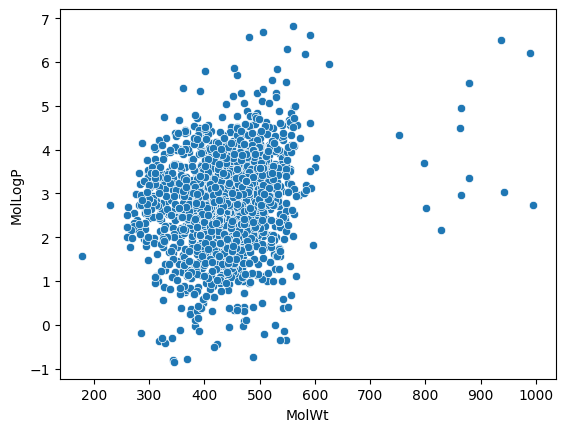

In [ ]:
sns.scatterplot(x='MolWt', y='MolLogP', data=X_train)

# 06. Model Baseline

In [ ]:
descriptor_df.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.0,...,1952.000000,1952.000000,1952.000000,1952.0,1952.000000,1952.000000,1952.0,1952.000000,1952.000000,1952.000000
mean,12.677679,-1.022795,12.677679,0.138557,0.508707,440.000165,415.182298,439.632588,164.799180,0.0,...,0.002561,0.027152,0.008709,0.0,0.002049,0.224385,0.0,0.053279,0.065574,0.005635
std,2.088214,1.191230,2.088214,0.123968,0.164376,75.239075,70.814106,75.200708,28.959057,0.0,...,0.050559,0.162567,0.092939,0.0,0.045233,0.430583,0.0,0.224646,0.545052,0.074876
min,4.363450,-5.881608,4.363450,0.000000,0.045219,179.219000,166.115000,179.094629,70.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,12.652592,-1.620366,12.652592,0.042760,0.394127,397.504000,376.294000,397.170565,148.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,13.131623,-0.576425,13.131623,0.118682,0.498561,442.015500,416.337000,441.678057,166.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,13.881538,-0.239197,13.881538,0.191757,0.603603,483.789250,457.343000,483.461550,182.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,15.555820,0.947848,15.555820,0.947848,0.945303,995.188000,924.628000,994.516405,388.000000,0.0,...,1.000000,1.000000,1.000000,0.0,1.000000,2.000000,0.0,1.000000,9.000000,1.000000


In [ ]:
descriptor_df = descriptor_df.drop(['fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_tetrazole', 'fr_thiazole',
                                    'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'], axis=1)
descriptor_df.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,...,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.0,1952.000000
mean,12.677679,-1.022795,12.677679,0.138557,0.508707,440.000165,415.182298,439.632588,164.799180,0.264252,...,0.215164,0.004611,0.004611,0.000512,0.000512,0.287398,0.063012,0.103484,0.0,0.951844
std,2.088214,1.191230,2.088214,0.123968,0.164376,75.239075,70.814106,75.200708,28.959057,0.052962,...,0.462666,0.067762,0.067762,0.022634,0.022634,0.514161,0.247229,0.306345,0.0,0.872577
min,4.363450,-5.881608,4.363450,0.000000,0.045219,179.219000,166.115000,179.094629,70.000000,0.116246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,12.652592,-1.620366,12.652592,0.042760,0.394127,397.504000,376.294000,397.170565,148.000000,0.254558,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,13.131623,-0.576425,13.131623,0.118682,0.498561,442.015500,416.337000,441.678057,166.000000,0.258416,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,13.881538,-0.239197,13.881538,0.191757,0.603603,483.789250,457.343000,483.461550,182.000000,0.264299,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000
max,15.555820,0.947848,15.555820,0.947848,0.945303,995.188000,924.628000,994.516405,388.000000,0.572596,...,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,0.0,3.000000


In [ ]:
cols = descriptor_df.columns
len(cols)

196

In [ ]:
cols

Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MaxPartialCharge',
       ...
       'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond',
       'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine',
       'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine'],
      dtype='object', length=196)

Robust Scaler

In [ ]:
Robust = RobustScaler()

In [ ]:
X_train = Robust.fit_transform(descriptor_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, train['IC50_nM'], test_size=0.25, random_state=seed)

# Model : Light GBM

In [ ]:
descriptor_df = descriptor_df.drop(['PEOE_VSA14', 'SMR_VSA9', 'SlogP_VSA7', 'SlogP_VS97' axis=1)

In [ ]:
descriptor_df.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,...,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.0,1952.000000
mean,12.677679,-1.022795,12.677679,0.138557,0.508707,440.000165,415.182298,439.632588,164.799180,0.264252,...,0.215164,0.004611,0.004611,0.000512,0.000512,0.287398,0.063012,0.103484,0.0,0.951844
std,2.088214,1.191230,2.088214,0.123968,0.164376,75.239075,70.814106,75.200708,28.959057,0.052962,...,0.462666,0.067762,0.067762,0.022634,0.022634,0.514161,0.247229,0.306345,0.0,0.872577
min,4.363450,-5.881608,4.363450,0.000000,0.045219,179.219000,166.115000,179.094629,70.000000,0.116246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,12.652592,-1.620366,12.652592,0.042760,0.394127,397.504000,376.294000,397.170565,148.000000,0.254558,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,13.131623,-0.576425,13.131623,0.118682,0.498561,442.015500,416.337000,441.678057,166.000000,0.258416,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,13.881538,-0.239197,13.881538,0.191757,0.603603,483.789250,457.343000,483.461550,182.000000,0.264299,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000
max,15.555820,0.947848,15.555820,0.947848,0.945303,995.188000,924.628000,994.516405,388.000000,0.572596,...,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,0.0,3.000000


In [ ]:
cols = descriptor_df.columns
len(cols)

196

In [ ]:
def extract_high_zero_ratio_columns(df, threshold=0.9):
    # Calculate the ratio of zero values in each column
    zero_ratio = (df == 0).mean()

    # Filter columns with a zero ratio greater than or equal to the threshold
    high_zero_columns = zero_ratio[zero_ratio >= threshold].index

    # Return the filtered DataFrame
    return df[high_zero_columns]

filtered_descriptor_df = extract_high_zero_ratio_columns(descriptor_df)

In [ ]:
len(filtered_descriptor_df.columns)

53

In [ ]:
train['IC50_nM'].to_csv('y_train', index=False)

In [ ]:
filtered_descriptor_df.to_csv('filtered_descriptor_df.csv', index=False)

# Model : RF Regression

In [ ]:
filtered_test_descriptor_df.to_csv('X_test.csv', index=False)

In [ ]:
rf_pred = rf_model.predict(X_test)
rf_submission = pd.DataFrame({'ID':test['ID'], 'IC50_nM':rf_pred * 0.23})
rf_submission.to_csv('rf_submission.csv', index=False)

Build RF Regression Model without Scaling

In [ ]:
rf_model_02 = RandomForestRegressor(n_estimators=100, random_state=seed)

In [ ]:
rf_model_02.fit(descriptor_df, train['IC50_nM'])

In [ ]:
rf_pred_02 = rf_model_02.predict(descriptor_test_df)

rf_submission = pd.DataFrame({'ID':test['ID'], 'IC50_nM':rf_pred_02 * 0.18})
rf_submission.to_csv('rf_submission_02.csv', index=False)

RF_pred 정리
- 0.22 : 0.4645651797
- 0.18 : 0.5012687637
- 0.2 : 0.530464909